In [1]:
####################################
# Objectives of this code are 
# 1. Save PCQ1, PCQ2, colq, colT
# 2. Calculate coh^2 between (1) PCQ1 and PCQ2 (2) pr and colq (3) pr and colT
# 2024.3.19
# Mu-Ting Chien
###############################################################

In [2]:
import numpy as np
import sys
sys.path.append('/glade/work/muting/function/')
import KW_diagnostics as KW

/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
DIR = '/glade/work/muting/'
dir_out = DIR+'KW/'
output_dir_all = dir_out+'output_data/All_3hr_10yr/'
CASENAME_LIST2 = list(['SST_AQP3_Qobs_27_-4K','SST_AQP3_Qobs_27','SST_AQP3_Qobs_27_4K'])

SST_AQP3_Qobs_27_-4K
saturation mse plev: 825


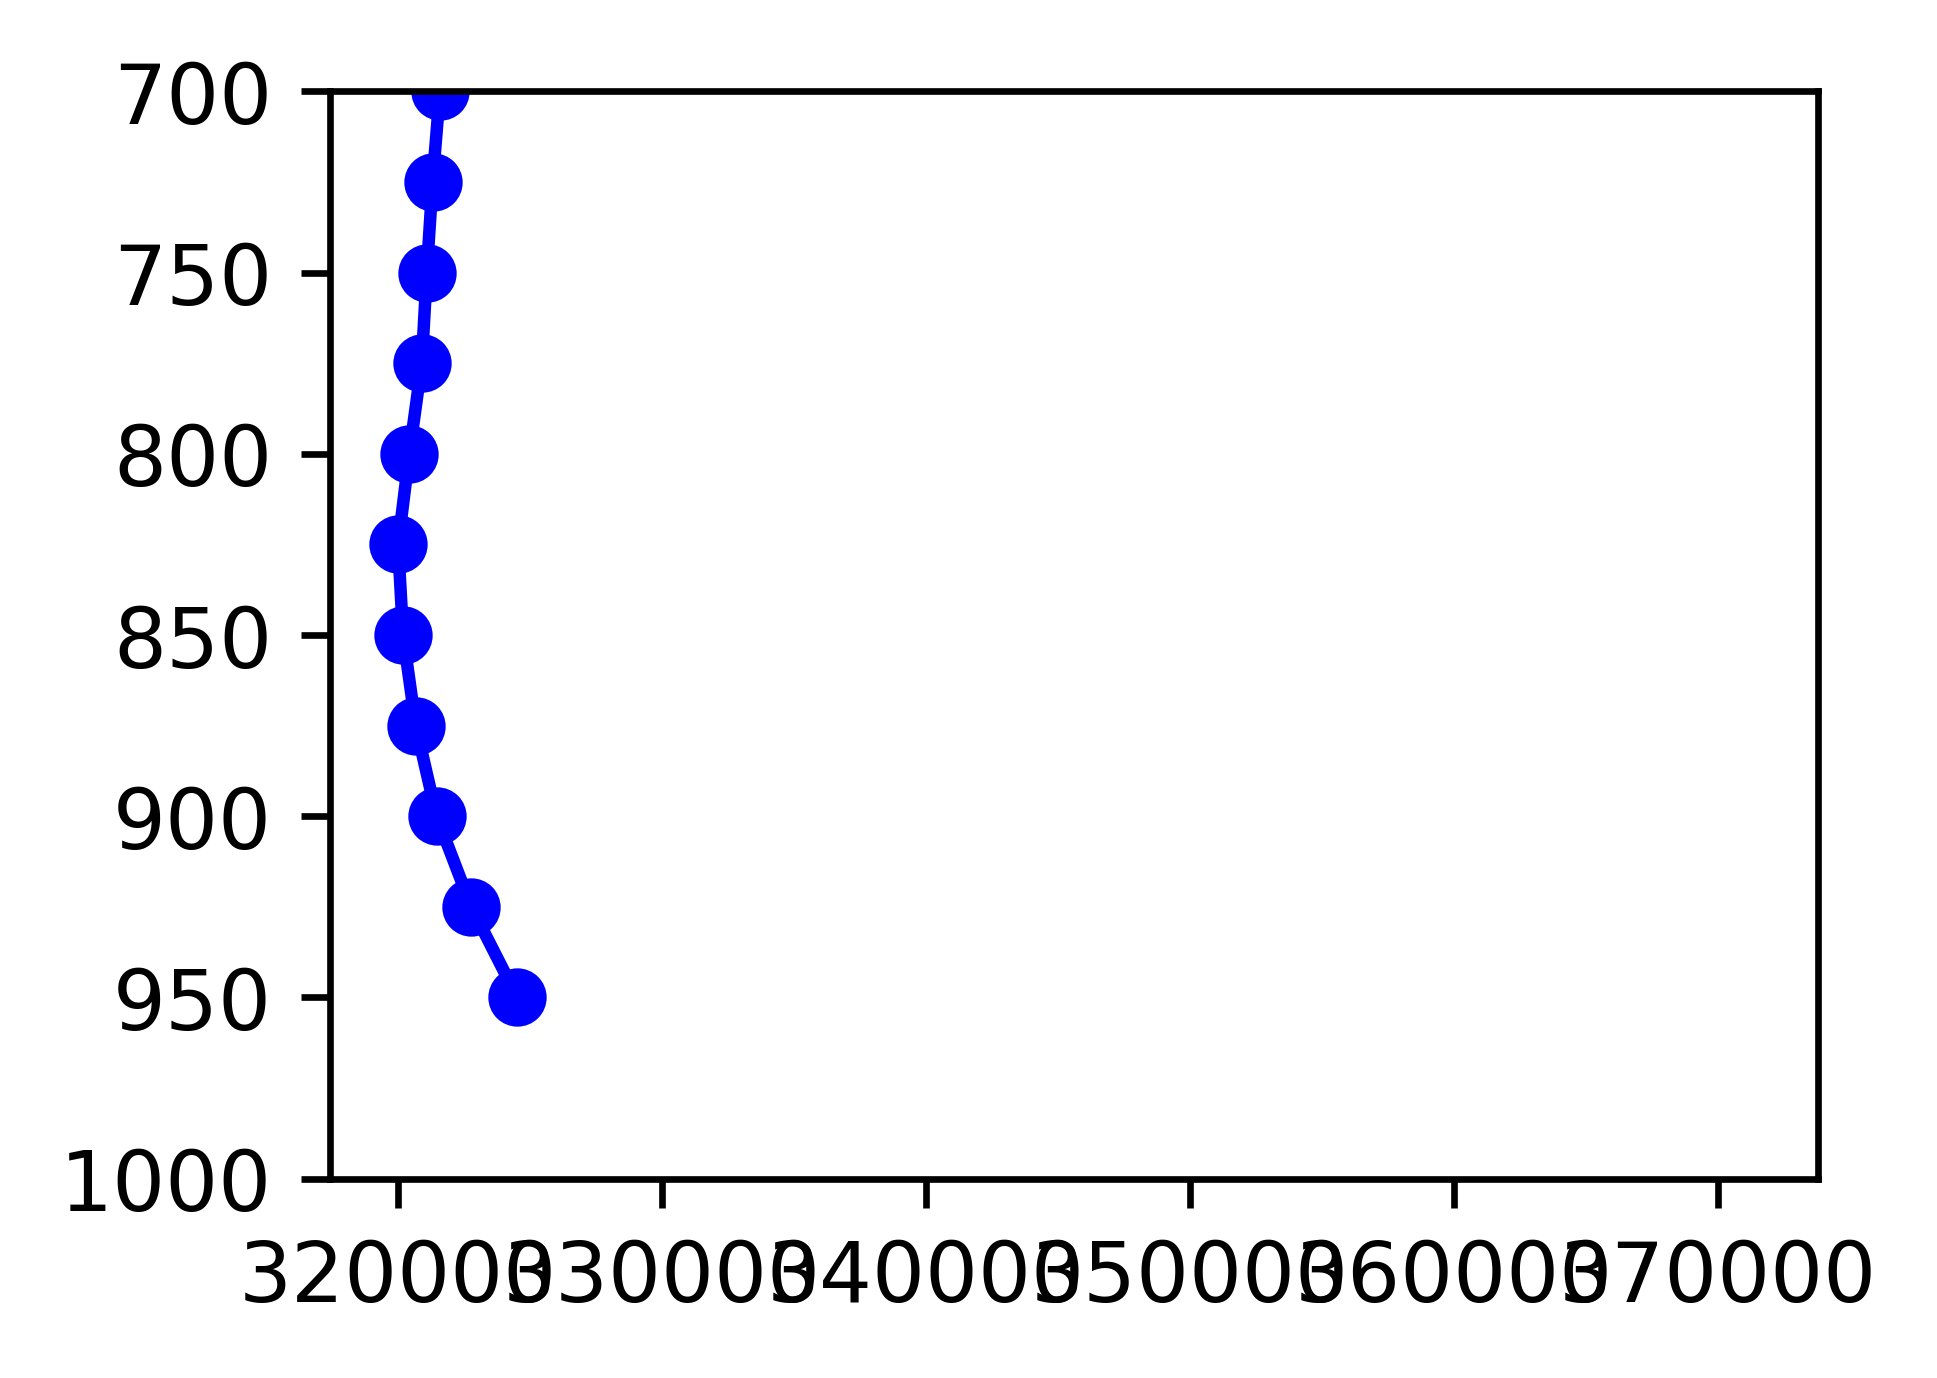

SST_AQP3_Qobs_27
saturation mse plev: 850


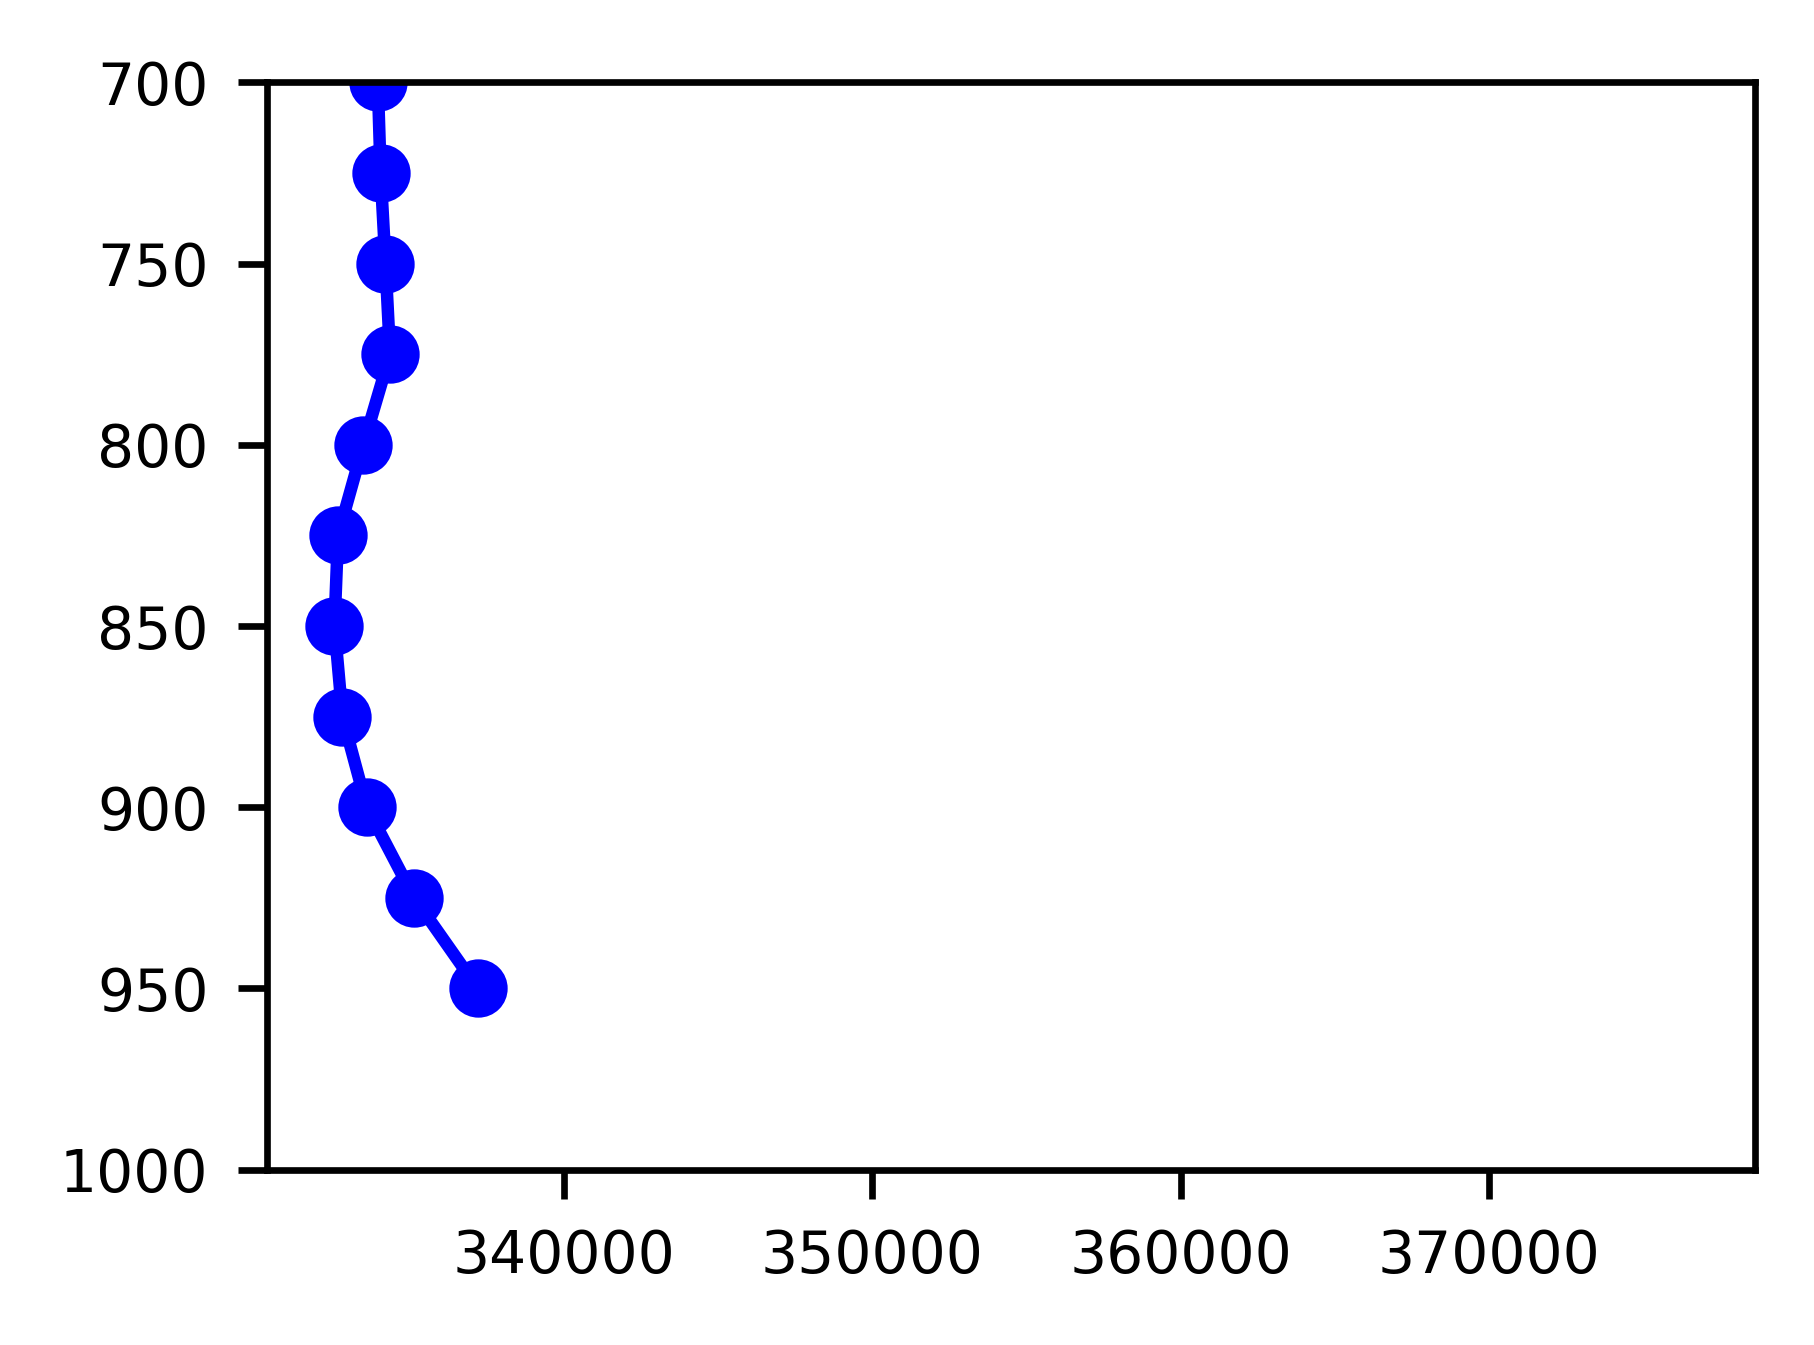

SST_AQP3_Qobs_27_4K
saturation mse plev: 850


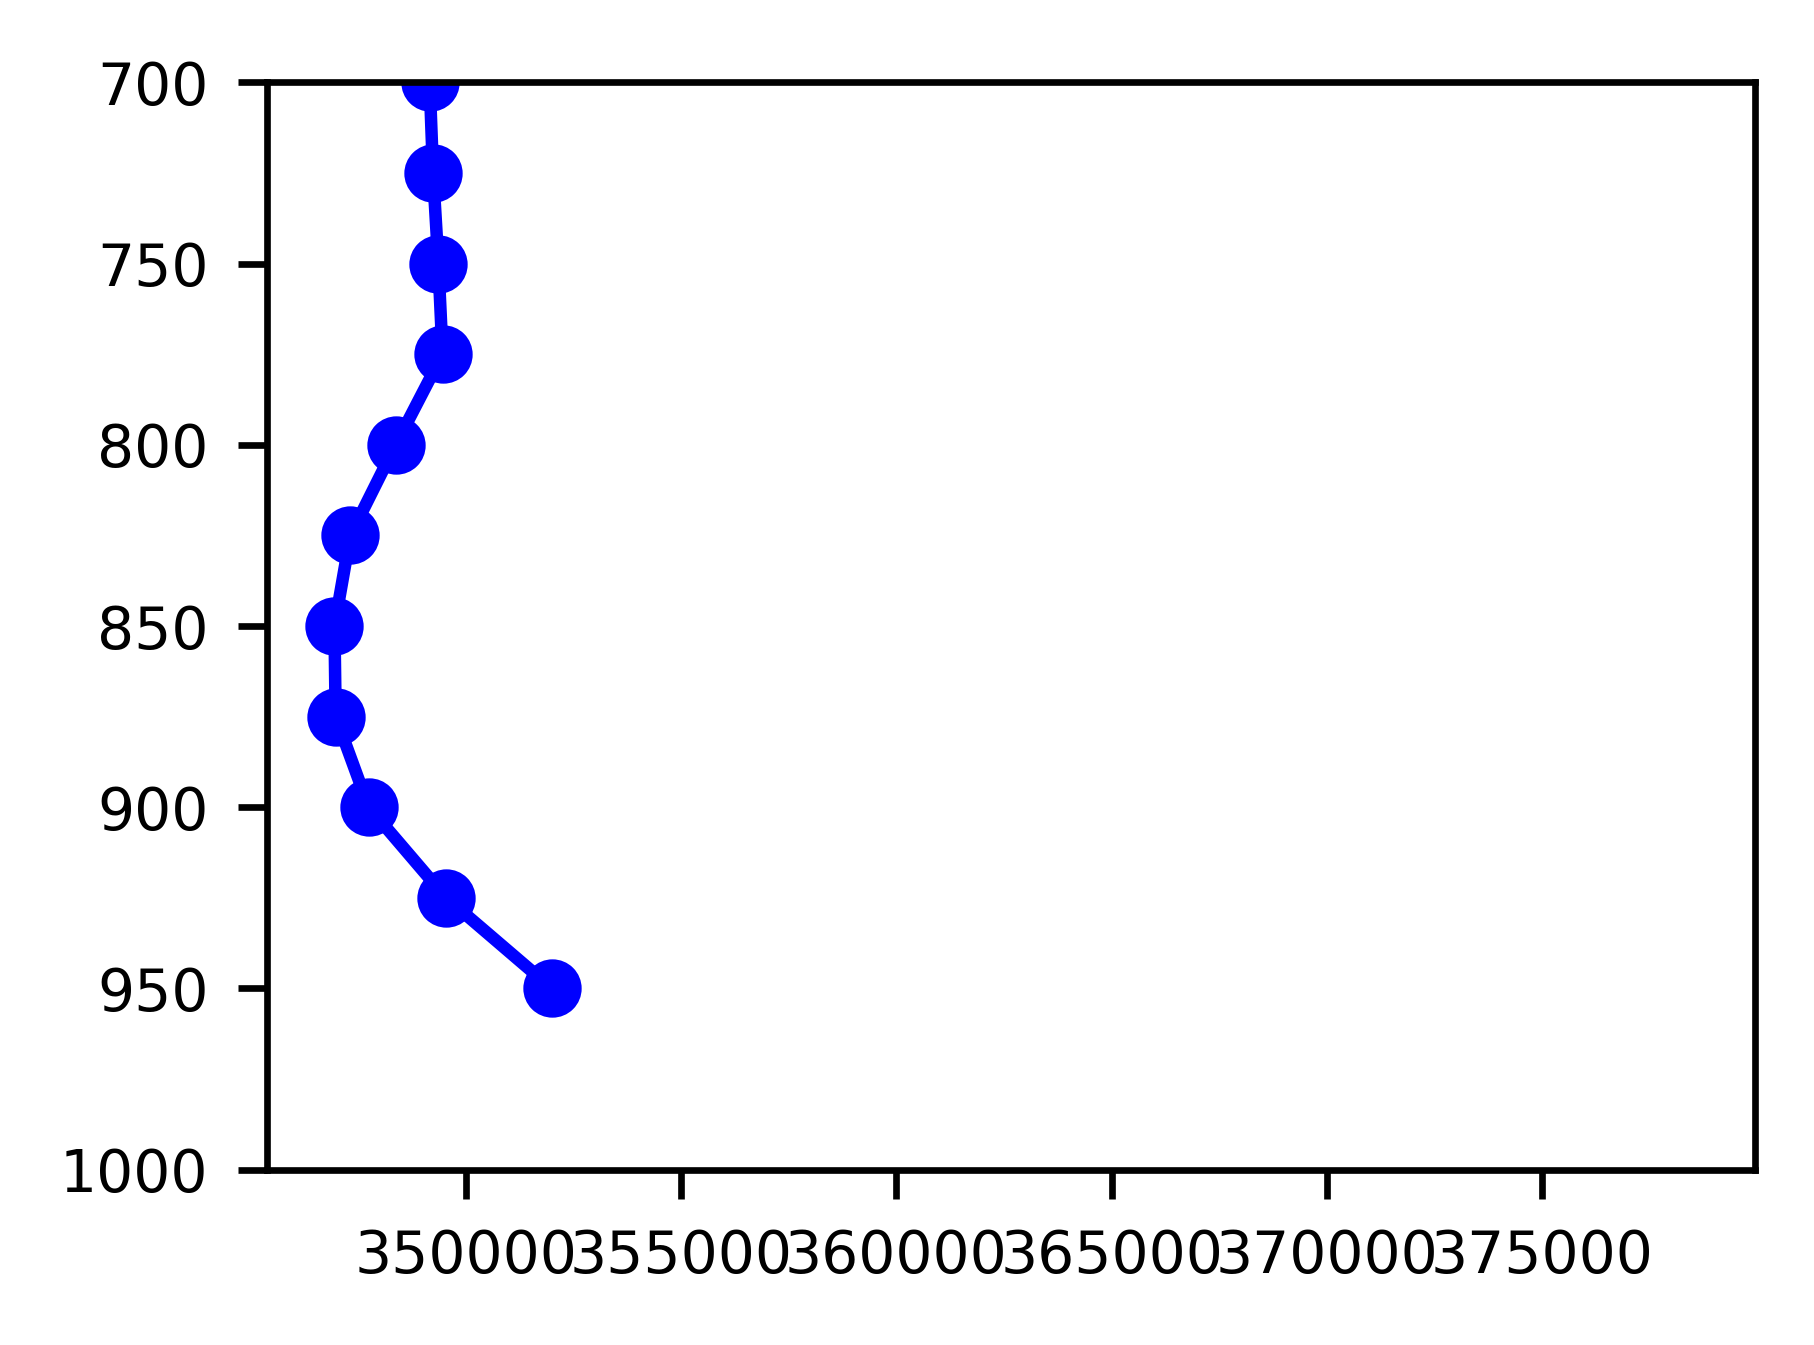

In [10]:
######################################################
# 1. Save data before calculating coh^2 (Calculate PCQ1, PCQ2, PW, DCIN) 
########################################################
save_data_before_spectrum = 1

if save_data_before_spectrum == 0:
    
    for icase in range(0,3):

        CASENAME = CASENAME_LIST2[icase]+'_3h_20y'
        output_dir = dir_out+'output_data/'+CASENAME+'/'
        print(CASENAME_LIST2[icase])
    
        data = np.load(output_dir+'QT.npz')
        plev  = data['plev']
        ilev_min = np.argwhere(plev==np.min(plev_ref)).squeeze()
        ilev_max = np.argwhere(plev==np.max(plev_ref)).squeeze()
        Q = data['Qproj'][:,ilev_min:ilev_max+1,:] #(time, plev, lon), raw Q data projected onto KW meridional structure
        time = data['time']
        lon  = data['lon']
        nt   = np.size(time)
        nlon = np.size(lon)
    
        PCQ1 = np.empty([nt, nlon])
        PCQ2 = np.empty([nt, nlon])
        PW   = np.empty([nt, nlon])
        colT = np.empty([nt, nlon])
        DCIN = np.empty([nt, nlon])
        SF   = np.empty([nt, nlon])
        pr   = np.empty([nt, nlon])
    
        # Load Q
        Q = np.transpose(Q, (0,2,1))
        Q_flat = np.reshape(Q, (nt*nlon, nlev_ref))
        tmp  = np.inner(Q_flat, EOFQ1[:,icase])
        PCQ1[:,:] = np.reshape(tmp, (nt, nlon))
        tmp  = np.inner(Q_flat, EOFQ2[:,icase])
        PCQ2[:,:] = np.reshape(tmp, (nt, nlon))
        del Q, Q_flat
    
        # Load T
        T = data['Tproj'][:,ilev_min:ilev_max+1,:]
        colT[:,:]  = KW.z_integrate_3d(T, plev_ref*100)
    
        # Load q
        data = np.load(output_dir+'kw_composite_rh_qv_phase_plev.npz')#,rh_kw=rh_kw, qv_kw=qv_kw, phase=phase, rh=rh, rh_ano=rh_ano, qv=qv, qv_ano=qv_ano, time=time, plev=plev, lon=lon)
        plev = data['plev']
        qv = data['qv'][:,ilev_min:ilev_max+1,:]
    
        # Load pr
        data = np.load(output_dir+'precip.npz')
        pr_raw = data['precip']
        lat    = data['lat']
        pr = KW.KW_meridional_projection(pr_raw, lat, tropics_or_midlat=0)
        del pr_raw
    
        ###########################
        # Calculate colq, SF
        #######################
        SF[:,:], PW[:,:], tmp = KW.calc_saturation_fraction(T, qv, plev_ref)
    
        np.savez(output_dir+'PCQ1_PCQ2_PR_PW_COLT_SF_t_lon.npz', PCQ1=PCQ1, PCQ2=PCQ2, pr=pr, PW=PW, colT=colT,\
                 time=time, lon=lon)    


else:
    data = np.load(output_dir+'PCQ1_PCQ2_PR_PW_COLT_SF_t_lon.npz')
    PCQ1 = data['PCQ1']
    PCQ2 = data['PCQ2']
    pr   = data['pr']
    PW   = data['PW']
    colT = data['colT']
    time = data['time']
    lon  = data['lon']

In [ ]:
###########################################
# 2. Calculate coh^2 between (1) PCQ1 and PCQ2, (2) pr and colT, (3) pr and colq
################################################
save_coh2 = 0
if save_coh2 == 0:
    # Load PW, DCIN
    for icase in range(0,3):

        CASENAME = CASENAME_LIST2[icase]+'_3h_20y'
        output_dir = dir_out+'output_data/'+CASENAME+'/'
        print(CASENAME_LIST2[icase])

        # Calculate anomaly
        PCQ1_ano = PCQ1-np.nanmean(PCQ1)
        PCQ2_ano = PCQ2-np.nanmean(PCQ2)
        pr_ano   = pr-np.nanmean(pr)
        PW_ano   = PW-np.nanmean(PW)
        colT_ano = colT-np.nanmean(colT)

        # Calculate cross spectrum
        tmp, tmp2, tmp3, tmp4, x, y, freq, zwnum = KW.calculate_coh2_spectrum(pr_ano, pr_ano)
        del tmp, tmp2, tmp3, tmp4
        n0 = np.size(x,0)
        n1 = np.size(x,1)
        if icase == 0:
            coh_pr_PW     = np.empty([n0, n1, 3])
            coh_pr_colT   = np.empty([n0, n1, 3])
            coh_PCQ1_PCQ2 = np.empty([n0, n1, 3])
            #
            cos_pr_PW     = np.empty([n0, n1, 3])
            cos_pr_colT   = np.empty([n0, n1, 3])
            cos_PCQ1_PCQ2 = np.empty([n0, n1, 3])    
            #
            sin_pr_PW     = np.empty([n0, n1, 3])
            sin_pr_colT   = np.empty([n0, n1, 3])
            sin_PCQ1_PCQ2 = np.empty([n0, n1, 3])

        coh_PCQ1_PCQ2[:,:,icase], sin_PCQ1_PCQ2[:,:,icase], cos_PCQ1_PCQ2[:,:,icase], coh_crit, x, y, freq, zwnum = KW.calculate_coh2_spectrum(PCQ2_ano, PCQ1_ano)
        coh_pr_PW[:,:,icase],     sin_pr_PW[:,:,icase],     cos_pr_PW[:,:,icase],    coh_crit, x, y, freq, zwnum = KW.calculate_coh2_spectrum(PW_ano, pr_ano)
        coh_pr_colT[:,:,icase],    sin_pr_colT[:,:,icase], cos_pr_colT[:,:,icase],   coh_crit, x, y, freq, zwnum = KW.calculate_coh2_spectrum(colT_ano, pr_ano)


    np.savez(output_dir_all+'coh2_spectrum.npz',\
                coh_PCQ1_PCQ2=coh_PCQ1_PCQ2, sin_PCQ1_PCQ2=sin_PCQ1_PCQ2, cos_PCQ1_PCQ2=cos_PCQ1_PCQ2,\
                coh_pr_PW=coh_pr_PW,         sin_pr_PW=sin_pr_PW,         cos_pr_PW=cos_pr_PW,\
                coh_pr_colT=coh_pr_colT,     sin_pr_colT=sin_pr_colT,     cos_pr_colT=cos_pr_colT,\
                x=x, y=y, freq=freq, zwnum=zwnum, coh_crit=coh_crit)
                                          